In [11]:
# 라이브러리 호출
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

from skimage.transform import iradon
from scipy.fft import fft, ifft, fftfreq, fftshift
from scipy.interpolate import interp1d
from scipy.ndimage import rotate


In [12]:
mat_path = r"./proj_assignment.mat"
mat_data = scipy.io.loadmat(mat_path)
sinogram = mat_data['p']

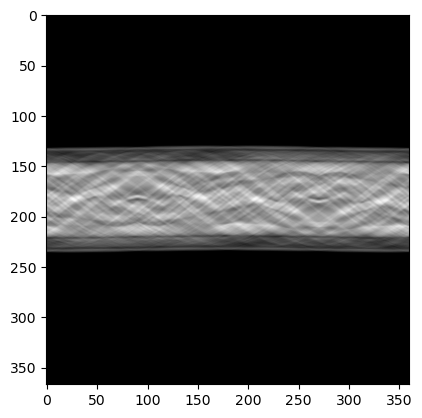

In [13]:
plt.imshow(sinogram, cmap = "gray")

In [23]:
# 각도 정의
theta = np.linspace(0., 360., max(sinogram[1].shape), endpoint=True)
# Filtered Backprojection을 이용한 이미지 재구성
reconstruction_fbp = iradon(sinogram, theta=theta, filter_name='ramp')

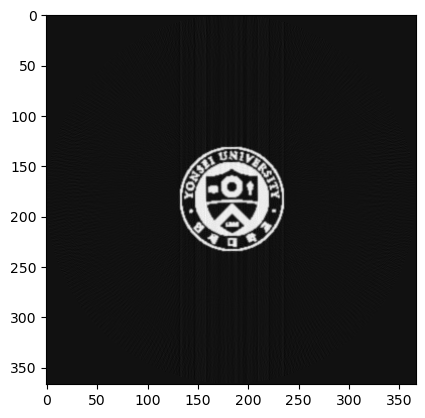

In [24]:
plt.imshow(reconstruction_fbp, cmap = "gray")

In [29]:
def convert_to_float(image, preserve_range):
    if image.dtype == np.float16:
        return image.astype(np.float32)
    
    if preserve_range:
        if image.dtype.char not in 'df':
            image = image.astype(float)
            
    return image

In [30]:
def _sinogram_circle_to_square(sinogram):
    diagonal = int(np.ceil(np.sqrt(2) * sinogram.shape[0]))
    pad = diagonal - sinogram.shape[0]
    old_center = sinogram.shape[0] // 2
    new_center = diagonal // 2
    pad_before = new_center - old_center
    pad_width = ((pad_before, pad - pad_before), (0, 0))
    return np.pad(sinogram, pad_width, mode='constant', constant_values=0)

In [31]:
def _get_fourier_filter(size, filter_name):
    n = np.concatenate(
        (
            np.arange(1, size / 2 + 1, 2, dtype=int),
            np.arange(size / 2 - 1, 0, -2, dtype=int),
        )
    )
    f = np.zeros(size)
    f[0] = 0.25
    f[1::2] = -1 / (np.pi * n) ** 2

    # Computing the ramp filter from the fourier transform of its
    # frequency domain representation lessens artifacts and removes a
    # small bias as explained in [1], Chap 3. Equation 61
    fourier_filter = 2 * np.real(fft(f))  # ramp filter
    if filter_name == "ramp":
        pass
    elif filter_name == "shepp-logan":
        # Start from first element to avoid divide by zero
        omega = np.pi * fftfreq(size)[1:]
        fourier_filter[1:] *= np.sin(omega) / omega
    elif filter_name == "cosine":
        freq = np.linspace(0, np.pi, size, endpoint=False)
        cosine_filter = fftshift(np.sin(freq))
        fourier_filter *= cosine_filter
    elif filter_name == "hamming":
        fourier_filter *= fftshift(np.hamming(size))
    elif filter_name == "hann":
        fourier_filter *= fftshift(np.hanning(size))
    elif filter_name is None:
        fourier_filter[:] = 1

    return fourier_filter[:, np.newaxis]

In [ ]:
def iradon_issac(
    radon_image,
    theta=None,
    output_size=None,
    filter_name="ramp",
    interpolation="linear",
    circle=True,
    preserve_range=True,
):
    # error check
    if radon_image.ndim != 2:
        raise ValueError('The input image must be 2-D')

    if theta is None:
        theta = np.linspace(0, 180, radon_image.shape[1], endpoint=False)

    angles_count = len(theta)
    if angles_count != radon_image.shape[1]:
        raise ValueError(
            "The given ``theta`` does not match the number of "
            "projections in ``radon_image``."
        )

    interpolation_types = ('linear', 'nearest', 'cubic')
    if interpolation not in interpolation_types:
        raise ValueError(f"Unknown interpolation: {interpolation}")

    filter_types = ('ramp', 'shepp-logan', 'cosine', 'hamming', 'hann', None)
    if filter_name not in filter_types:
        raise ValueError(f"Unknown filter: {filter_name}")

    radon_image = convert_to_float(radon_image, preserve_range)
    dtype = radon_image.dtype
    
    img_shape = radon_image.shape[0]
    if output_size is None:
        # If output size not specified, estimate from input radon image
        if circle:
            output_size = img_shape
        else:
            output_size = int(np.floor(np.sqrt((img_shape) ** 2 / 2.0)))

    if circle:
        radon_image = _sinogram_circle_to_square(radon_image)
        img_shape = radon_image.shape[0]

    # Resize image to next power of two (but no less than 64) for
    # Fourier analysis; speeds up Fourier and lessens artifacts
    projection_size_padded = max(64, int(2 ** np.ceil(np.log2(2 * img_shape))))
    pad_width = ((0, projection_size_padded - img_shape), (0, 0))
    img = np.pad(radon_image, pad_width, mode='constant', constant_values=0)

    # Apply filter in Fourier domain
    fourier_filter = _get_fourier_filter(projection_size_padded, filter_name)
    projection = fft(img, axis=0) * fourier_filter
    radon_filtered = np.real(ifft(projection, axis=0)[:img_shape, :])

    # Reconstruct image by interpolation
    reconstructed = np.zeros((output_size, output_size), dtype=dtype)
    radius = output_size // 2
    xpr, ypr = np.mgrid[:output_size, :output_size] - radius
    x = np.arange(img_shape) - img_shape // 2

    for col, angle in zip(radon_filtered.T, np.deg2rad(theta)):
        t = ypr * np.cos(angle) - xpr * np.sin(angle)
        if interpolation == 'linear':
            interpolant = partial(np.interp, xp=x, fp=col, left=0, right=0)
        else:
            interpolant = interp1d(
                x, col, kind=interpolation, bounds_error=False, fill_value=0
            )
        reconstructed += interpolant(t)
        
    if circle:
        out_reconstruction_circle = (xpr**2 + ypr**2) > radius**2
        reconstructed[out_reconstruction_circle] = 0.0

    return reconstructed * np.pi / (2 * angles_count)